# Baseline Model

## Table of Contents
1. [Model Choice](#model-choice)
2. [Feature Selection](#feature-selection)
3. [Implementation](#implementation)
4. [Evaluation](#evaluation)


In [ ]:
!pip install openpyxl

In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import shutil
import random
import os
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, mean_squared_error
# Import your chosen baseline model
# Example: from sklearn.linear_model import LogisticRegression


## Load dataset
Load preprocessed dataset and print basic details.

### Directory preparation

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import zipfile

# Replace 'path/to/your/zipped_folder.zip' with the actual path to your zipped folder in Google Drive.
zip_path = '/content/drive/MyDrive/opencampus_all_files/Rider1_preprocessed.zip'

# Extract the contents of the zip file to a specified directory.
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall('/content/Rider1_preprocessed')
print(f"Successfully unzipped {zip_path} to /content/unzipped_folder")


Successfully unzipped /content/drive/MyDrive/opencampus_all_files/Rider1_preprocessed.zip to /content/unzipped_folder


In [4]:
source_dir = '/content/Rider1_preprocessed/content/content/Sport_xlsx/Rider1_preprocessed'
destination_dir = '/content/Rider1_preprocessed'

# Iterate through all files in the source directory
for filename in os.listdir(source_dir):
    source_path = os.path.join(source_dir, filename)
    destination_path = os.path.join(destination_dir, filename)

    # Check if it's a file (not a subdirectory)
    if os.path.isfile(source_path):
        # Move the file
        shutil.move(source_path, destination_path)

In [5]:
# Define the directory to clean
directory_to_clean = '/content/Rider1_preprocessed'

# Check if the directory exists
if os.path.exists(directory_to_clean):
    for filename in os.listdir(directory_to_clean):
        filepath = os.path.join(directory_to_clean, filename)
        try:
            if os.path.isdir(filepath):
                shutil.rmtree(filepath)  # Remove folders recursively
                print(f"Removed directory: {filepath}")
        except OSError as e:
            print(f"Error removing {filepath}: {e}")
else:
    print(f"Directory '{directory_to_clean}' not found.")

Removed directory: /content/Rider1_preprocessed/content


### Explore dataset

In [6]:
# Load example file
df = pd.read_excel('/content/Rider1_preprocessed/f1.xlsx')

# Show features
df.head()

,Latitude,Longitude,Elevation,Time,Distance
0,46.363649,14.112036,511.5,0,0.000000
1,46.363691,14.112026,511.0,1,4.731651
2,46.363778,14.112031,510.1,3,14.410085
3,46.363835,14.112023,509.7,5,20.775954
4,46.363888,14.112007,509.4,7,26.794638


In [7]:
# Print the range of all columns in the DataFrame
for col in df.columns:
    print(f"Column '{col}': Min = {df[col].min()}, Max = {df[col].max()}")

Column 'Latitude': Min = 46.338096, Max = 46.422636
Column 'Longitude': Min = 13.919303, Max = 14.112036
Column 'Elevation': Min = 480.8, Max = 1659.9
Column 'Time': Min = 0, Max = 20896
Column 'Distance': Min = 0.0, Max = 61367.54987900978


## Model Choice

In following notebook two models were implemented:
- Linear Regression
- Neural Network


## Feature engineering

#### Prepare pipeline

In [9]:
# Assuming 'df' is your DataFrame as defined in the previous code.
df['Latitude_prev'] = df['Latitude'].shift(1)
df['Longitude_prev'] = df['Longitude'].shift(1)
df['Elevation_prev'] = df['Elevation'].shift(1)
df['Latitude_next'] = df['Latitude'].shift(-1)
df['Longitude_next'] = df['Longitude'].shift(-1)
df['Elevation_next'] = df['Elevation'].shift(-1)

# Calculate speed based on distance and time differences
df['Time_prev'] = df['Time'].shift(1)
df['Time_next'] = df['Time'].shift(-1)
df['Distance_prev'] = df['Distance'].shift(1)
df['Distance_next'] = df['Distance'].shift(-1)

# Calculate time difference
df['Time_diff_prev'] = df['Time'] - df['Time_prev']
df['Time_diff_next'] = df['Time_next'] - df['Time']

# Calculate distance difference
df['Distance_diff_prev'] = df['Distance'] - df['Distance_prev']
df['Distance_diff_next'] = df['Distance_next'] - df['Distance']

# Calculate speed (m/s)
df['Speed'] = (df['Distance_diff_next'] + df['Distance_diff_prev']) / (df['Time_diff_next'] + df['Time_diff_prev'])

# Calculate the total elevation gain
df['Elevation_diff'] = df['Elevation'] - df['Elevation_prev']
df['total_elev_gain'] = df['Elevation_diff'].cumsum()

# Replace negative elevation differences with 0
df['total_elev_gain'] = df['total_elev_gain'].clip(lower=0)

# Calculate slope
df['Slope'] = (df['Elevation'] - df['Elevation_prev']) / (df['Distance'] - df['Distance_prev'])

# Handle potential divisions by zero
df['Slope'] = df['Slope'].fillna(0).replace([float('inf'), -float('inf')], 0)

# Drop additional columns
df = df.drop(['Latitude', 'Longitude', 'Time', 'Latitude_prev', 'Latitude_next', 'Longitude_prev', 'Longitude_next', 'Time_prev', 'Time_next', 'Distance_prev', 'Distance_next', 'Time_diff_prev', 'Time_diff_next', 'Distance_diff_prev', 'Distance_diff_next',
              'Elevation_diff'], axis=1)

print(df.head())

   Elevation   Distance  Elevation_prev  Elevation_next     Speed  \
0      511.5   0.000000             NaN           511.0       NaN   
1      511.0   4.731651           511.5           510.1  4.803362   
2      510.1  14.410085           511.0           509.7  4.011076   
3      509.7  20.775954           510.1           509.4  3.096138   
4      509.4  26.794638           509.7           509.0  3.053427   

   total_elev_gain     Slope  
0              NaN  0.000000  
1              0.0 -0.105671  
2              0.0 -0.092990  
3              0.0 -0.062835  
4              0.0 -0.049845  


#### Apply features

In [10]:
def move_random_files(source_dir, destination_dir, num_files):
    # Get a list of all files in the source directory
    files = [f for f in os.listdir(source_dir) if os.path.isfile(os.path.join(source_dir, f))]

    # Check if there are enough files to move
    if len(files) < num_files:
        print(f"Not enough files in {source_dir}. Moving {len(files)} files.")
        num_files = len(files)

    # Randomly select files
    selected_files = random.sample(files, num_files)

    # Move the selected files to the destination directory
    for file in selected_files:
        source_path = os.path.join(source_dir, file)
        destination_path = os.path.join(destination_dir, file)
        try:
            shutil.move(source_path, destination_path)
            print(f"Moved {file} to {destination_dir}")
        except Exception as e:
            print(f"Error moving {file}: {e}")

# Example usage
source_directory = '/content/Rider1_preprocessed'
destination_directory = '/content/Rider1_test'
number_of_files = 10

# Create destination directory if it does not exist
if not os.path.exists(destination_directory):
    os.makedirs(destination_directory)

move_random_files(source_directory, destination_directory, number_of_files)

Moved f670.xlsx to /content/Rider1_test
Moved f409.xlsx to /content/Rider1_test
Moved f641.xlsx to /content/Rider1_test
Moved f624.xlsx to /content/Rider1_test
Moved f272.xlsx to /content/Rider1_test
Moved f441.xlsx to /content/Rider1_test
Moved f527.xlsx to /content/Rider1_test
Moved f46.xlsx to /content/Rider1_test
Moved f102.xlsx to /content/Rider1_test
Moved f435.xlsx to /content/Rider1_test


In [11]:
# Directory containing the Excel files
directory = '/content/Rider1_preprocessed'

# Initialize an empty list to store DataFrames
dataframes = []

# Iterate over all files in the directory
for filename in os.listdir(directory):
    if filename.endswith('.xlsx'):  # Process only .xlsx files
        filepath = os.path.join(directory, filename)

        # Read the Excel file into a DataFrame
        df = pd.read_excel(filepath)

        # Apply preprocessing
        df['Latitude_prev'] = df['Latitude'].shift(1)
        df['Longitude_prev'] = df['Longitude'].shift(1)
        df['Elevation_prev'] = df['Elevation'].shift(1)
        df['Latitude_next'] = df['Latitude'].shift(-1)
        df['Longitude_next'] = df['Longitude'].shift(-1)
        df['Elevation_next'] = df['Elevation'].shift(-1)

        df['Time_prev'] = df['Time'].shift(1)
        df['Time_next'] = df['Time'].shift(-1)
        df['Distance_prev'] = df['Distance'].shift(1)
        df['Distance_next'] = df['Distance'].shift(-1)

        df['Time_diff_prev'] = df['Time'] - df['Time_prev']
        df['Time_diff_next'] = df['Time_next'] - df['Time']

        df['Distance_diff_prev'] = df['Distance'] - df['Distance_prev']
        df['Distance_diff_next'] = df['Distance_next'] - df['Distance']

        df['Speed'] = (df['Distance_diff_next'] + df['Distance_diff_prev']) / (df['Time_diff_next'] + df['Time_diff_prev'])

        df['Elevation_diff'] = df['Elevation'] - df['Elevation_prev']
        df['total_elev_gain'] = df['Elevation_diff'].cumsum()
        df['total_elev_gain'] = df['total_elev_gain'].clip(lower=0)

        # Calculate slope
        df['Slope'] = (df['Elevation'] - df['Elevation_prev']) / (df['Distance'] - df['Distance_prev'])

        # Handle potential divisions by zero
        df['Slope'] = df['Slope'].fillna(0).replace([float('inf'), -float('inf')], 0)

        # Drop additional columns
        df = df.drop(['Latitude', 'Longitude', 'Time', 'Latitude_prev', 'Latitude_next', 'Longitude_prev', 'Longitude_next',
                      'Time_prev', 'Time_next', 'Distance_prev', 'Distance_next', 'Time_diff_prev', 'Time_diff_next',
                      'Distance_diff_prev', 'Distance_diff_next', 'Elevation_diff'], axis=1)

        # Drop NaN values
        df.dropna(inplace=True)

        # Append the processed DataFrame to the list
        dataframes.append(df)

# Combine all DataFrames into a single DataFrame
combined_df = pd.concat(dataframes, ignore_index=True)

# Display the first few rows of the combined DataFrame
print(combined_df.head())

# Save the combined DataFrame to a file (optional)
combined_df.to_csv('/content/combined_data.csv', index=False)


   Elevation   Distance  Elevation_prev  Elevation_next     Speed  \
0      244.0  23.318461           244.0           244.0  7.940400   
1      244.0  47.642403           244.0           244.0  7.918255   
2      244.0  54.991482           244.0           244.0  7.861233   
3      244.0  63.364869           244.0           244.0  7.969182   
4      244.0  70.929847           244.0           244.0  7.969184   

   total_elev_gain  Slope  
0              0.0    0.0  
1              0.0    0.0  
2              0.0    0.0  
3              0.0    0.0  
4              0.0    0.0  


## Feature Selection

Selected features describes terrain characteristics and cumulative statistics of current track.

In [20]:
# Load the dataset
# Replace 'your_dataset.csv' with the path to your actual dataset
df = pd.read_csv('/content/combined_data.csv')

# Feature selection
# Example: Selecting only two features for a simple baseline model
X = df[['Elevation', 'Elevation_prev', 'Elevation_next', 'Slope', 'Distance', 'total_elev_gain']] # Add elevation_prev and elevation_next
y = df['Speed']

# Splitting the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [21]:
# Size of datasets
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)


X_train shape: (3644802, 6)
X_test shape: (911201, 6)
y_train shape: (3644802,)
y_test shape: (911201,)


## Implementation

[Implement your baseline model here.]



#### Baseline model 1 - Linear Regression

In [14]:
import numpy as np
from sklearn.linear_model import LinearRegression

# Initialize and train the model
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

# Make predictions
y_pred = lr_model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error: {mse}")

Mean Squared Error: 15.616364704993739


#### Baseline model 2 - Simple Neural Network

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
113901/113901 ━━━━━━━━━━━━━━━━━━━━ 241s 2ms/step - loss: 10.9252 - mae: 2.2305 - val_loss: 9.9114 - val_mae: 2.0601
Epoch 2/10
113901/113901 ━━━━━━━━━━━━━━━━━━━━ 265s 2ms/step - loss: 9.8142 - mae: 2.0647 - val_loss: 9.5146 - val_mae: 2.0162
Epoch 3/10
113901/113901 ━━━━━━━━━━━━━━━━━━━━ 234s 2ms/step - loss: 9.6358 - mae: 2.0206 - val_loss: 8.8023 - val_mae: 1.9243
Epoch 4/10
113901/113901 ━━━━━━━━━━━━━━━━━━━━ 243s 2ms/step - loss: 8.5007 - mae: 1.9448 - val_loss: 8.6575 - val_mae: 1.9146
Epoch 5/10
113901/113901 ━━━━━━━━━━━━━━━━━━━━ 372s 3ms/step - loss: 8.4892 - mae: 1.8893 - val_loss: 8.1510 - val_mae: 1.8518
Epoch 6/10
113901/113901 ━━━━━━━━━━━━━━━━━━━━ 287s 2ms/step - loss: 7.9915 - mae: 1.8253 - val_loss: 7.8203 - val_mae: 1.7707
Epoch 7/10
113901/113901 ━━━━━━━━━━━━━━━━━━━━ 266s 2ms/step - loss: 7.5143 - mae: 1.7859 - val_loss: 7.5047 - val_mae: 1.7373
Epoch 8/10
113901/113901 ━━━━━━━━━━━━━━━━━━━━ 306s 2ms/step - loss: 7.5526 - mae: 1.7670 - val_loss: 7.4127 - val_mae

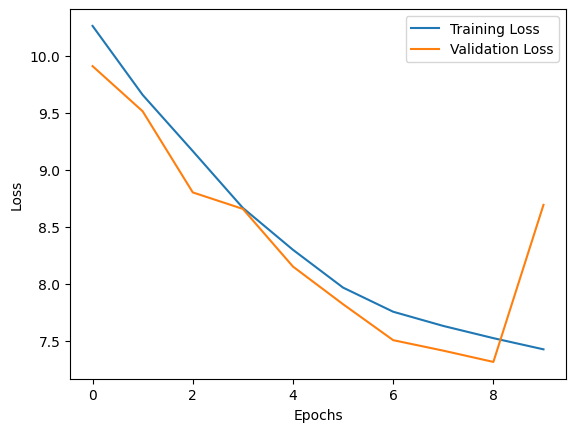

In [24]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import pandas as pd

# Normalize the features using StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Build the neural network model
model = Sequential([
    Dense(64, input_dim=X_train.shape[1], activation='relu'),  # First hidden layer
    Dense(32, activation='relu'),  # Second hidden layer
    Dense(1, activation='relu')  # Output layer (no activation since we're doing regression)
])

# Compile the model
model.compile(optimizer=Adam(), loss='mean_squared_error', metrics=['mae'])

# Train the model
history = model.fit(X_train_scaled, y_train, epochs=10, batch_size=32, validation_data=(X_test_scaled, y_test))

# Evaluate the model
loss, mae = model.evaluate(X_test_scaled, y_test)
print(f"Test Loss: {loss}, Test MAE: {mae}")

# Optionally, plot the training history (e.g., loss or MAE over epochs)
import matplotlib.pyplot as plt
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

## Evaluation

Evaluation based on loss and MAE.


#### Preprocess test file

In [31]:
# Prepare test file
df = pd.read_excel('/content/Rider1_test/f102.xlsx')

# Assuming 'df' is your DataFrame as defined in the previous code.
df['Latitude_prev'] = df['Latitude'].shift(1)
df['Longitude_prev'] = df['Longitude'].shift(1)
df['Elevation_prev'] = df['Elevation'].shift(1)
df['Latitude_next'] = df['Latitude'].shift(-1)
df['Longitude_next'] = df['Longitude'].shift(-1)
df['Elevation_next'] = df['Elevation'].shift(-1)

# Calculate speed based on distance and time differences
df['Time_prev'] = df['Time'].shift(1)
df['Time_next'] = df['Time'].shift(-1)
df['Distance_prev'] = df['Distance'].shift(1)
df['Distance_next'] = df['Distance'].shift(-1)

# Calculate time difference
df['Time_diff_prev'] = df['Time'] - df['Time_prev']
df['Time_diff_next'] = df['Time_next'] - df['Time']

# Calculate distance difference
df['Distance_diff_prev'] = df['Distance'] - df['Distance_prev']
df['Distance_diff_next'] = df['Distance_next'] - df['Distance']

# Calculate speed (m/s)
df['Speed'] = (df['Distance_diff_next'] + df['Distance_diff_prev']) / (df['Time_diff_next'] + df['Time_diff_prev'])

# Calculate the total elevation gain
df['Elevation_diff'] = df['Elevation'] - df['Elevation_prev']
df['total_elev_gain'] = df['Elevation_diff'].cumsum()

# Replace negative elevation differences with 0
df['total_elev_gain'] = df['total_elev_gain'].clip(lower=0)

# Calculate slope
df['Slope'] = (df['Elevation'] - df['Elevation_prev']) / (df['Distance'] - df['Distance_prev'])

# Handle potential divisions by zero
df['Slope'] = df['Slope'].fillna(0).replace([float('inf'), -float('inf')], 0)

# Drop additional columns
df = df.drop(['Latitude', 'Longitude', 'Latitude_prev', 'Latitude_next', 'Longitude_prev', 'Longitude_next', 'Time_prev', 'Time_next', 'Distance_prev', 'Distance_next', 'Time_diff_prev', 'Time_diff_next', 'Distance_diff_prev', 'Distance_diff_next',
              'Elevation_diff'], axis=1)

df.dropna(inplace=True)

print(df.head())

   Elevation  Time   Distance  Elevation_prev  Elevation_next     Speed  \
1      245.0     3  12.239734           245.0           245.0  4.364024   
2      245.0     6  26.184141           245.0           245.0  4.872850   
3      245.0     7  31.731136           245.0           245.0  5.498843   
4      245.0     8  37.181827           245.0           245.0  7.029610   
5      245.0     9  45.790356           245.0           245.0  8.138246   

   total_elev_gain  Slope  
1              0.0    0.0  
2              0.0    0.0  
3              0.0    0.0  
4              0.0    0.0  
5              0.0    0.0  


In [32]:
# Feature selection
# Example: Selecting only two features for a simple baseline model
real_time = df['Time']
X = df[['Elevation', 'Elevation_prev', 'Elevation_next', 'Slope', 'Distance', 'total_elev_gain']]
y = df['Speed']


#### Evaluation 1 - Linear Regression

In [19]:
# Make predictions on the new data
y_pred = lr_model.predict(X)

# Add the predicted values as a new column 'Speed_pred' in the original DataFrame
df['Speed_pred'] = y_pred

# Optionally, check the first few rows to verify the new column is added correctly
print(df.head())


   Elevation   Distance  Elevation_prev  Elevation_next     Speed  \
1      245.0  12.239734           245.0           245.0  4.364024   
2      245.0  26.184141           245.0           245.0  4.872850   
3      245.0  31.731136           245.0           245.0  5.498843   
4      245.0  37.181827           245.0           245.0  7.029610   
5      245.0  45.790356           245.0           245.0  8.138246   

   total_elev_gain  Slope  Speed_pred  
1              0.0    0.0    6.374397  
2              0.0    0.0    6.374873  
3              0.0    0.0    6.375063  
4              0.0    0.0    6.375249  
5              0.0    0.0    6.375544  


#### Evaluation 2 - Neural Network

In [34]:
# Normalize the new data using the same scaler fitted on the training data
X_new_scaled = scaler.transform(X)

# Make predictions on the new data
y_pred = model.predict(X_new_scaled)

# Add the predicted values as a new column 'Speed_pred' in the original DataFrame
df['Speed_pred'] = y_pred
df['real_time'] = real_time

# Optionally, check the first few rows to verify the new column is added correctly
print(df.head())


114/114 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
   Elevation  Time   Distance  Elevation_prev  Elevation_next     Speed  \
1      245.0     3  12.239734           245.0           245.0  4.364024   
2      245.0     6  26.184141           245.0           245.0  4.872850   
3      245.0     7  31.731136           245.0           245.0  5.498843   
4      245.0     8  37.181827           245.0           245.0  7.029610   
5      245.0     9  45.790356           245.0           245.0  8.138246   

   total_elev_gain  Slope  Speed_pred  real_time  
1              0.0    0.0    0.811109          3  
2              0.0    0.0    0.906949          6  
3              0.0    0.0    0.945063          7  
4              0.0    0.0    0.982526          8  
5              0.0    0.0    1.041658          9  


In [35]:
df.head()

,Elevation,Time,Distance,Elevation_prev,Elevation_next,Speed,total_elev_gain,Slope,Speed_pred,real_time
1,245.0,3,12.239734,245.0,245.0,4.364024,0.0,0.0,0.811109,3
2,245.0,6,26.184141,245.0,245.0,4.872850,0.0,0.0,0.906949,6
3,245.0,7,31.731136,245.0,245.0,5.498843,0.0,0.0,0.945063,7
4,245.0,8,37.181827,245.0,245.0,7.029610,0.0,0.0,0.982526,8
5,245.0,9,45.790356,245.0,245.0,8.138246,0.0,0.0,1.041658,9


## Evaluate track length in seconds

### Example code

In [ ]:
import pandas as pd
import numpy as np

# Data
data = {
    'Speed': [np.nan, 4.606892, 5.372097, 6.147122, 6.584172],
    'Distance': [0.0, 4.111612, 9.213784, 14.855806, 21.508028]
}
df = pd.DataFrame(data)

# Initialize Time column
df['Time'] = 0.0

# Compute Time intelligently
for i in range(1, len(df)):
    if pd.notna(df.loc[i, 'Speed']):
        df.loc[i, 'Time'] = df.loc[i - 1, 'Time'] + (df.loc[i, 'Distance'] - df.loc[i - 1, 'Distance']) / df.loc[i, 'Speed']

print(df)

      Speed   Distance      Time
0       NaN   0.000000  0.000000
1  4.606892   4.111612  0.892492
2  5.372097   9.213784  1.842246
3  6.147122  14.855806  2.760077
4  6.584172  21.508028  3.770413


### Implementation on test route

In [43]:
# Initialize Time column
df['pred_time'] = 0.0

# Compute predicted time
for i in range(2, len(df)):
    if pd.notna(df.loc[i, 'Speed_pred']):
      if df.loc[i, 'Speed_pred'] != 0:
        df.loc[i, 'pred_time'] = df.loc[i - 1, 'pred_time'] + (df.loc[i, 'Distance'] - df.loc[i - 1, 'Distance']) / df.loc[i, 'Speed_pred']
      else:
        df.loc[i, 'pred_time'] = df.loc[i - 1, 'pred_time']

print(df)

      Elevation  Time      Distance  Elevation_prev  Elevation_next     Speed  \
1         245.0     3     12.239734           245.0           245.0  4.364024   
2         245.0     6     26.184141           245.0           245.0  4.872850   
3         245.0     7     31.731136           245.0           245.0  5.498843   
4         245.0     8     37.181827           245.0           245.0  7.029610   
5         245.0     9     45.790356           245.0           245.0  8.138246   
...         ...   ...           ...             ...             ...       ...   
3632      240.4  3688  15807.894595           240.4           240.4  5.602182   
3633      240.4  3689  15813.411331           240.4           240.4  5.476310   
3634      240.4  3690  15818.847215           240.4           240.4  5.397081   
3635      240.4  3691  15824.205493           240.4           240.4  5.455657   
3636      240.4  3692  15829.758528           240.4           240.4  5.553036   

      total_elev_gain  Slop

In [45]:
df[['Speed', 'Speed_pred', 'real_time', 'pred_time']].head()

,Speed,Speed_pred,real_time,pred_time
1,4.364024,0.811109,3,0.000000
2,4.872850,0.906949,6,15.375080
3,5.498843,0.945063,7,21.244524
4,7.029610,0.982526,8,26.792157
5,8.138246,1.041658,9,35.056416
